# L09.1 Latent Factor Model with Pytorch
---
이름: 김태산

학과: 자동차공학과

학번: 20143211

---

## 과제 목표: Latent Factor Model로 예상 별점 구하기

### MovieLens 데이터
- 대표적인 영화 평점 데이터셋으로, 데이터의 크기별로 다양한 데이터셋이 존재한다.
- 실습에서 사용할 데이터셋은 크기가 100k인 데이터셋이다.

### Colab에서 구글드라이브 연결하기
1. Colab에서 구글 드라이브 mount하기

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


2. 파일 확인하기

In [ ]:
!ls "/content/gdrive/My Drive/datasets/MovieLens"

ml-100k.zip  ua.base  ua.test


### Pytorch 사용하기
1. 필요한 모듈 import 하기

In [ ]:
import torch
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt

### 파일 불어오기
1. 판다스를 이용하여 파일 불러오기
  - 이번 실습에 사용할 ua.base와 ua.test는 ','가 아닌 탭으로 구분되어 있는 데이터셋이다.
  - sep 파라미터에 '\t'를 입력하면 탭으로 구분되어 있는 데이터를 읽어들일 수 있다.
  - names 파라미터는 아래의 출력과 같이 데이터셋을 읽어들일 때 데이터의 이름을 지정할 수 있다.

In [ ]:
train = pd.read_csv("/content/gdrive/My Drive/datasets/MovieLens/ua.base",  sep="\t", names=['user', 'movie', 'rating', 'timestamp'])
test = pd.read_csv("/content/gdrive/My Drive/datasets/MovieLens/ua.test",  sep="\t", names=['user', 'movie', 'rating', 'timestamp'])
train

,user,movie,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
90565,943,1047,2,875502146
90566,943,1074,4,888640250
90567,943,1188,3,888640250
90568,943,1228,3,888640275


2.  pytorch tensor 데이터로 변환
  - Pytorch를 이용하여 Latent Factor Model을 학습시킬 것이므로, 훈련 데이터와 테스트 데이터를 텐서로 생성한다.

In [ ]:
items = torch.LongTensor(train['movie'])
users = torch.LongTensor(train['user'])
ratings = torch.FloatTensor(train['rating'])
items_test = torch.LongTensor(test['movie'])
users_test = torch.LongTensor(test['user'])
ratings_test = torch.FloatTensor(test['rating'])

### Latent Factor Model
- rank: 사용자 vector와 아이템 vector의 차원
- numItems: 아이템 수
- numUsers: 사용자 수
- P: 아이템 매트릭스
- Q: 사용자 매트릭스

In [ ]:
rank = 10
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

- 기본 Matrix Factorization 구현
 - 아래와 같은 가설 함수와 비용을 정의하여 Latent Factor Model을 학습시킨다.
 > 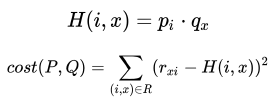
 - 출력 결과를 보면, epoch가 커질수록 cost가 감소하므로 훈련이 잘 진행된 것을 알 수 있다.
 - 그러나 cost가 0.4 이상으로 비교적 큰 값을 가지므로 좋은 성능을 낸다고는 볼 수 없다.

- Matplotlib으로 epoch마다 Training MSE 그려보기

In [ ]:
optimizer = torch.optim.Adam([P, Q], lr=0.1)

X = []
Y = []

for epoch in range(1001):
  hypothesis = torch.sum(P[items] * Q[users], dim=1) # dim=1로 지정하면 행 방향으로 모든 요소를 더하여 리턴한다.
  mse = F.mse_loss(hypothesis, ratings)

  optimizer.zero_grad()
  mse.backward()
  optimizer.step()

  X.append(epoch)
  Y.append(mse.item())

  if epoch % 100 == 0:
    print(f"epoch: {epoch}, cost: {mse:.6f}")

epoch: 0, cost: 23.536058
epoch: 100, cost: 0.560848
epoch: 200, cost: 0.490854
epoch: 300, cost: 0.469428
epoch: 400, cost: 0.459556
epoch: 500, cost: 0.454029
epoch: 600, cost: 0.450091
epoch: 700, cost: 0.447378
epoch: 800, cost: 0.445526
epoch: 900, cost: 0.444169
epoch: 1000, cost: 0.443089


- Matplotlib으로 epoch마다 Training MSE 그려보기
  - epoch 마다 Training MSE를 그린 결과를 보면, epoch가 증가할수록 MSE가 감소하므로 훈련이 잘 되고 있음을 알 수 있다.

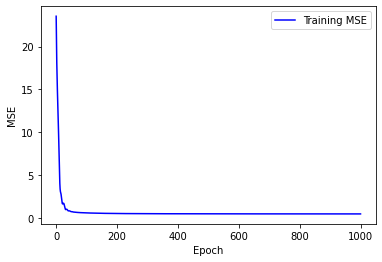

In [ ]:
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X, Y, c="blue", label="Training MSE")
plt.legend()
plt.show()

- Matplotlib으로 epoch 마다 Test MSE 그려보기



In [ ]:
rank = 10
numItems = items.max() + 1
numUsers = users.max() + 1

P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

optimizer = torch.optim.Adam([P, Q], lr=0.1)

X = []
Y = []
Y_test = []

for epoch in range(1001):
  hypothesis = torch.sum(P[items] * Q[users], dim=1)
  mse = F.mse_loss(hypothesis, ratings)

  optimizer.zero_grad()
  mse.backward()
  optimizer.step()

  X.append(epoch)
  Y.append(mse.item())

  with torch.no_grad():
    hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1)
    mse_test = F.mse_loss(hypo_test, ratings_test)
    Y_test.append(mse_test.item())

  if epoch % 100 == 0:
    print(f"epoch: {epoch}, cost: {mse:.6f}")

epoch: 0, cost: 23.780148
epoch: 100, cost: 0.561798
epoch: 200, cost: 0.491671
epoch: 300, cost: 0.469429
epoch: 400, cost: 0.458832
epoch: 500, cost: 0.452865
epoch: 600, cost: 0.449183
epoch: 700, cost: 0.446675
epoch: 800, cost: 0.444848
epoch: 900, cost: 0.443444
epoch: 1000, cost: 0.442342


- Matplotlib으로 epoch 마다 Test MSE 그려보기
  - 아래의 그래프를 보면, epoch가 증가할수록 Training MSE는 감소하지만, Test MSE는 초반에만 감소하고 뒤로 갈수록 값이 오히려 증가하는 것을 알 수 있다.
  - 따라서 훈련시킨 latent factor model이 훈련데이터에만 잘 맞도록 과대적합된 것으로 볼 수 있다.

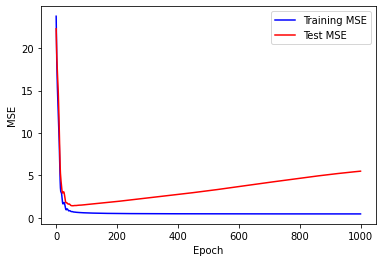

In [ ]:
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X, Y, c="blue", label="Training MSE")
plt.plot(X, Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

### Regularization
- Regularization 추가하기
 - latent factor model이 학습 데이터에 과대적합되는 것을 방지하기 위해 cost 함수에 regularization을 추가한다.
 - 하이퍼파라미터 lambda1과 lambda2에 아이템 매트릭스 P와 사용자 매트릭스 Q의 L2 norm의 제곱을 곱하여 cost 함수에 더해준 형태이다.
 - regularization 항이 추가되면, P와 Q의 값이 작게 유지된다.
 - P와 Q가 너무 큰 값을 가지면 아이템과 사용자 벡터가 약간만 바뀌어도 cost가 크게 변하므로 훈련 데이터와 다른 테스트 데이터를 입력하였을 때 cost가 커지게 되는 원인이 된다.
 - 따라서 regularizaion 항을 추가하여 P와 Q를 작게 유지함으로써 모델이 훈련 데이터에 과대적합되는 것을 방지한다.

In [ ]:
rank = 10
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

X = []
Y = []
Y_test = []

optimizer = torch.optim.Adam([P, Q], lr=0.1)

lambda1 = 0.0001
lambda2 = 0.0001

for epoch in range(1001):
  hypothesis = torch.sum(P[items] * Q[users], dim=1)
  mse = F.mse_loss(hypothesis, ratings)
  cost = mse + lambda1 * (P ** 2).sum() + lambda2 * (Q ** 2).sum()

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  X.append(epoch)
  Y.append(mse.item())

  with torch.no_grad():
    hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1)
    mse_test = F.mse_loss(hypo_test, ratings_test)
    Y_test.append(mse_test.item())
  
  if epoch % 100 == 0:
    print(f"epoch: {epoch}, cost: {mse.item():.6f}")

epoch: 0, cost: 23.797733
epoch: 100, cost: 0.702824
epoch: 200, cost: 0.649383
epoch: 300, cost: 0.635503
epoch: 400, cost: 0.630362
epoch: 500, cost: 0.627865
epoch: 600, cost: 0.627009
epoch: 700, cost: 0.626694
epoch: 800, cost: 0.626510
epoch: 900, cost: 0.626352
epoch: 1000, cost: 0.626235


- Regularization 추가하기
 - 그래프 결과를 보면, epoch가 증가할수록 Training MSE와 Test MSE가 모두 감소하는 것을 알 수 있다.
 - 따라서 latent factor model이 훈련 데이터에 과대적합되지 않고 테스트 데이터를 입력하였을 때에도 결과를 잘 출력하는 것을 알 수 있다.

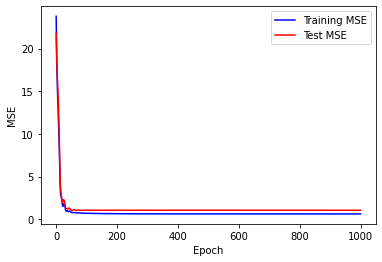

In [ ]:
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X, Y, c="blue", label="Training MSE")
plt.plot(X, Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

### Bias
- Bias 추가하기
  - latent factor model도 별점 정보가 많지 않을 경우 학습이 제대로 진행되지 않는다.
  - 이 때 별점 정보가 없는 영화를 보완하기 위해 Global Baseline Estimate를 추가하여 모델의 학습을 진행한다.

In [ ]:
rank = 10
numItems = items.max() + 1
numUsers = users.max() + 1

P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
bias_item = torch.randn(numItems, requires_grad=True)
mean = (ratings.sum() / len(ratings)).item()

X = []
Y = []
Y_test = []

optimizer = torch.optim.Adam([P, Q], lr=0.1)

lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.001
lambda4 = 0.001

for epoch in range(1001):
  hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]
  mse = F.mse_loss(hypothesis, ratings)
  cost = mse + lambda1 * (P ** 2).sum() + lambda2 * (Q ** 2).sum() + lambda3 * (bias_item ** 2).sum() + lambda4 * (bias_user ** 2).sum()

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  X.append(epoch)
  Y.append(mse.item())

  with torch.no_grad():
    hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1) + mean + bias_item[items_test] + bias_user[users_test]
    mse_test = F.mse_loss(hypo_test, ratings_test)
    Y_test.append(mse_test.item())
  
  if epoch % 100 == 0:
    print(f"epoch: {epoch}, cost: {mse.item():.6f}, test_cost: {mse_test.item():.6f}")    

epoch: 0, cost: 13.344730, test_cost: 10.673506
epoch: 100, cost: 0.671568, test_cost: 1.108387
epoch: 200, cost: 0.642328, test_cost: 1.101698
epoch: 300, cost: 0.638844, test_cost: 1.101508
epoch: 400, cost: 0.638283, test_cost: 1.102010
epoch: 500, cost: 0.637947, test_cost: 1.101980
epoch: 600, cost: 0.637535, test_cost: 1.101905
epoch: 700, cost: 0.637183, test_cost: 1.102055
epoch: 800, cost: 0.637092, test_cost: 1.102126
epoch: 900, cost: 0.637112, test_cost: 1.102227
epoch: 1000, cost: 0.637151, test_cost: 1.102348


- Bias 추가하기
 - 출력 결과를 보면, epoch가 증가할수록 Training MSE가 감소하면서 과대적합은 되지 않아 Test MSE 또한 감소하는 것을 확인할 수 있다.

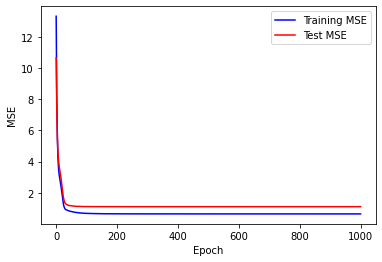

In [ ]:
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X, Y, c="blue", label="Training MSE")
plt.plot(X, Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

### Test MSE가 최소가 되도록 파라미터를 다양하게 조절
1. rank의 값을 기존보다 감소시켜 사용자와 아이템 벡터의 길이를 짧아지도록 만든다.

In [ ]:
rank = 4
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
bias_item = torch.randn(numItems, requires_grad=True)
mean = (ratings.sum() / len(ratings)).item()

X = []
Y = []
Y_test1 = []

optimizer = torch.optim.Adam([P, Q], lr=0.1)

lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.001
lambda4 = 0.001

for epoch in range(1001):
  hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]
  mse = F.mse_loss(hypothesis, ratings)
  cost = mse + lambda1 * (P ** 2).sum() + lambda2 * (Q ** 2).sum() + lambda3 * (bias_item ** 2).sum() + lambda4 * (bias_user ** 2).sum()

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  X.append(epoch)
  Y.append(mse.item())

  with torch.no_grad():
    hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1) + mean + bias_item[items_test] + bias_user[users_test]
    mse_test = F.mse_loss(hypo_test, ratings_test)
    Y_test1.append(mse_test.item())
  
  if epoch % 100 == 0:
    print(f"epoch: {epoch}, test_cost: {mse_test.item():.6f}")    

epoch: 0, test_cost: 6.135010
epoch: 100, test_cost: 1.096316
epoch: 200, test_cost: 1.076812
epoch: 300, test_cost: 1.073970
epoch: 400, test_cost: 1.072725
epoch: 500, test_cost: 1.072334
epoch: 600, test_cost: 1.072246
epoch: 700, test_cost: 1.072232
epoch: 800, test_cost: 1.072231
epoch: 900, test_cost: 1.072230
epoch: 1000, test_cost: 1.072229


- 출력 그래프에서 label이 Before인 그래프는 과제의 강의 자료에서 Bias까지 추가하였을 때 Test MSE를 계산한 결과이다.
- rank를 기존에 10에서 4로 변경하였을 때 벡터의 길이는 짧아졌지만, Test MSE는 기존보다 작아진 것을 확인할 수 있다.

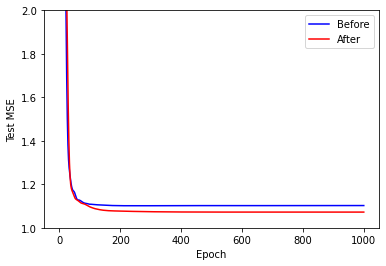

In [ ]:
plt.ylabel("Test MSE")
plt.xlabel("Epoch")
plt.plot(X, Y_test, c="blue", label="Before")
plt.plot(X, Y_test1, c="red", label="After")
plt.axis([-50, 1050, 1, 2])
plt.legend()
plt.show()

2. lambda1와 lambda2의 값을 기존보다 감소시켜 regularization의 정도를 변화시킨다.

In [ ]:
rank = 10
numItems = items.max() + 1
numUsers = users.max() + 1

P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
bias_item = torch.randn(numItems, requires_grad=True)
mean = ratings.sum() / len(ratings)

optimizer = torch.optim.Adam([P, Q], lr=0.1)

X = []
Y = []
Y_test2 = []

lambda1 = 0.00005
lambda2 = 0.00005
lambda3 = 0.001
lambda4 = 0.001

for epoch in range(1001):
  hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]
  mse = F.mse_loss(hypothesis, ratings)
  cost = mse + lambda1 * (P ** 2).sum() + lambda2 * (Q ** 2).sum() + lambda3 * (bias_item ** 2).sum() + lambda4 * (bias_user ** 2).sum()

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  with torch.no_grad():
    hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1) + mean + bias_item[items_test] + bias_user[users_test]
    mse_test = F.mse_loss(hypo_test, ratings_test)
    Y_test2.append(mse_test.item())

  X.append(epoch)
  Y.append(mse.item())

  if epoch % 100 == 0:
    print(f"epoch: {epoch}, cost:{mse.item():.6f}, test_cost: {mse_test.item():.6f}")    

epoch: 0, cost:13.470721, test_cost: 10.808843
epoch: 100, cost:0.586325, test_cost: 1.054530
epoch: 200, cost:0.554010, test_cost: 1.039036
epoch: 300, cost:0.548260, test_cost: 1.036712
epoch: 400, cost:0.546781, test_cost: 1.036616
epoch: 500, cost:0.546047, test_cost: 1.037649
epoch: 600, cost:0.545688, test_cost: 1.038415
epoch: 700, cost:0.545537, test_cost: 1.038370
epoch: 800, cost:0.545472, test_cost: 1.038207
epoch: 900, cost:0.545432, test_cost: 1.038159
epoch: 1000, cost:0.545396, test_cost: 1.038197


- lambda1와 lambda2를 기존에 0.0001에서 0.00005로 변경하였을 때 Test MSE가 기존보다 작아진 것을 확인할 수 있다.

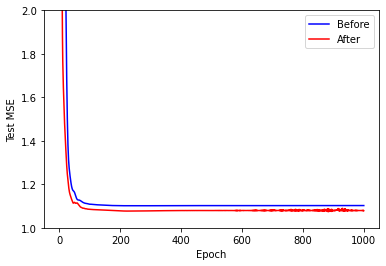

In [ ]:
plt.ylabel("Test MSE")
plt.xlabel("Epoch")
plt.plot(X, Y_test, c="blue", label="Before")
plt.plot(X, Y_test2, c="red", label="After")
plt.axis([-50, 1050, 1, 2])
plt.legend()
plt.show()

3. lambda3와 lambda4의 값을 기존보다 감소시켜 regularization의 정도를 변화시킨다.

In [ ]:
rank = 10
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
bias_item = torch.randn(numItems, requires_grad=True)
mean = (ratings.sum() / len(ratings)).item()

X = []
Y = []
Y_test3 = []

optimizer = torch.optim.Adam([P, Q], lr=0.1)

lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.00001
lambda4 = 0.00001

for epoch in range(1001):
  hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]
  mse = F.mse_loss(hypothesis, ratings)
  cost = mse + lambda1 * (P ** 2).sum() + lambda2 * (Q ** 2).sum() + lambda3 * (bias_item ** 2).sum() + lambda4 * (bias_user ** 2).sum()

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  X.append(epoch)
  Y.append(mse.item())

  with torch.no_grad():
    hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1) + mean + bias_item[items_test] + bias_user[users_test]
    mse_test = F.mse_loss(hypo_test, ratings_test)
    Y_test3.append(mse_test.item())
  
  if epoch % 100 == 0:
    print(f"epoch: {epoch}, cost:{mse.item():.6f}, test_cost: {mse_test.item():.6f}")    

epoch: 0, cost:13.041809, test_cost: 10.618274
epoch: 100, cost:0.668115, test_cost: 1.062638
epoch: 200, cost:0.642616, test_cost: 1.058177
epoch: 300, cost:0.639543, test_cost: 1.056261
epoch: 400, cost:0.637963, test_cost: 1.054806
epoch: 500, cost:0.637083, test_cost: 1.054940
epoch: 600, cost:0.636897, test_cost: 1.054893
epoch: 700, cost:0.636850, test_cost: 1.054901
epoch: 800, cost:0.636858, test_cost: 1.054908
epoch: 900, cost:0.636865, test_cost: 1.054957
epoch: 1000, cost:0.636888, test_cost: 1.054972


- lambda3와 lambda4를 기존에 0.001에서 0.00001로 변경하였을 때 Test MSE가 기존보다 작아진 것을 확인할 수 있다.

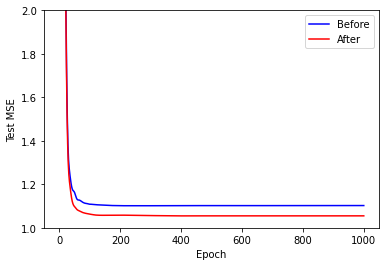

In [ ]:
plt.ylabel("Test MSE")
plt.xlabel("Epoch")
plt.plot(X, Y_test, c="blue", label="Before")
plt.plot(X, Y_test3, c="red", label="After")
plt.axis([-50, 1050, 1, 2])
plt.legend()
plt.show()

4. optimizer의 학습률 lr을 낮춰 가중치를 기존보다 작은 정도로 갱신한다.

In [ ]:
rank = 10
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
bias_item = torch.randn(numItems, requires_grad=True)
mean = (ratings.sum() / len(ratings)).item()

X = []
Y = []
Y_test4 = []

optimizer = torch.optim.Adam([P, Q], lr=0.05)

lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.001
lambda4 = 0.001

for epoch in range(1001):
  hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]
  mse = F.mse_loss(hypothesis, ratings)
  cost = mse + lambda1 * (P ** 2).sum() + lambda2 * (Q ** 2).sum() + lambda3 * (bias_item ** 2).sum() + lambda4 * (bias_user ** 2).sum()

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  X_test4.append(epoch)
  Y.append(mse.item())

  with torch.no_grad():
    hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1) + mean + bias_item[items_test] + bias_user[users_test]
    mse_test = F.mse_loss(hypo_test, ratings_test)
    Y_test4.append(mse_test.item())
  
  if epoch % 100 == 0:
    print(f"epoch: {epoch}, cost:{mse.item():.6f}, test_cost: {mse_test.item():.6f}")    

epoch: 0, cost:13.663868, test_cost: 12.093121
epoch: 100, cost:0.754681, test_cost: 1.133780
epoch: 200, cost:0.669922, test_cost: 1.092999
epoch: 300, cost:0.651477, test_cost: 1.089137
epoch: 400, cost:0.646006, test_cost: 1.086905
epoch: 500, cost:0.643515, test_cost: 1.086636
epoch: 600, cost:0.642025, test_cost: 1.086772
epoch: 700, cost:0.641162, test_cost: 1.086691
epoch: 800, cost:0.640703, test_cost: 1.086746
epoch: 900, cost:0.640423, test_cost: 1.087097
epoch: 1000, cost:0.640233, test_cost: 1.087646


- lr을 기존의 0.1에서 0.05로 변경하였을 때 Test MSE가 기존보다 작아진 것을 확인할 수 있다.

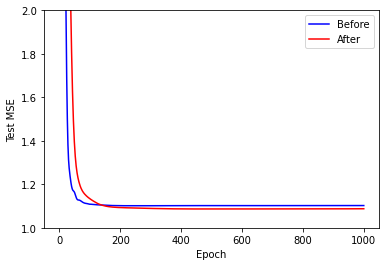

In [ ]:
plt.ylabel("Test MSE")
plt.xlabel("Epoch")
plt.plot(X, Y_test, c="blue", label="Before")
plt.plot(X, Y_test4, c="red", label="After")
plt.axis([-50, 1050, 1, 2])
plt.legend()
plt.show()

#### 지금까지 Test MSE를 줄이기 위한 방법들을 모두 합하여 결과를 출력한다.

In [ ]:
rank = 4
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
bias_item = torch.randn(numItems, requires_grad=True)
mean = (ratings.sum() / len(ratings)).item()

X = []
Y = []
Y_test5 = []

optimizer = torch.optim.Adam([P, Q], lr=0.05)

lambda1 = 0.00005
lambda2 = 0.00005
lambda3 = 0.00001
lambda4 = 0.00001

for epoch in range(1001):
  hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]
  mse = F.mse_loss(hypothesis, ratings)
  cost = mse + lambda1 * (P ** 2).sum() + lambda2 * (Q ** 2).sum() + lambda3 * (bias_item ** 2).sum() + lambda4 * (bias_user ** 2).sum()

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  X.append(epoch)
  Y.append(mse.item())

  with torch.no_grad():
    hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1) + mean + bias_item[items_test] + bias_user[users_test]
    mse_test = F.mse_loss(hypo_test, ratings_test)
    Y_test5.append(mse_test.item())
  
  if epoch % 100 == 0:
    print(f"epoch: {epoch}, cost:{mse.item():.6f}, test_cost: {mse_test.item():.6f}")    

epoch: 0, cost:7.678678, test_cost: 6.866953
epoch: 100, cost:0.779479, test_cost: 1.023901
epoch: 200, cost:0.721916, test_cost: 0.996850
epoch: 300, cost:0.713831, test_cost: 0.988563
epoch: 400, cost:0.711753, test_cost: 0.986989
epoch: 500, cost:0.710899, test_cost: 0.986505
epoch: 600, cost:0.710448, test_cost: 0.986457
epoch: 700, cost:0.710226, test_cost: 0.986541
epoch: 800, cost:0.710121, test_cost: 0.986605
epoch: 900, cost:0.710072, test_cost: 0.986633
epoch: 1000, cost:0.710048, test_cost: 0.986641


- 출력 결과를 보면, Before의 Test MSE보다 확연하게 After의 Test MSE가 줄어들었음을 알 수 있다.
- Before의 Test MSE는 1.0 이상의 값을 보이지만, After의 Test MSE는 1.0 이하의 값으로 떨어진 것을 확인할 수 있다.

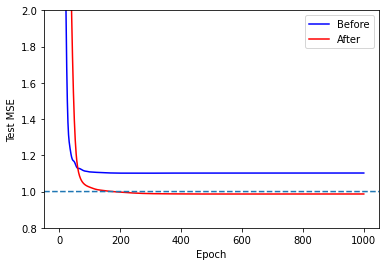

In [ ]:
plt.ylabel("Test MSE")
plt.xlabel("Epoch")
plt.plot(X, Y_test, c="blue", label="Before")
plt.plot(X, Y_test5, c="red", label="After")
plt.plot([x for x in range(-50, 1051)], [1.0]*1101, "--")
plt.axis([-50, 1050, 0.8, 2])
plt.legend()
plt.show()